# Open Earth Foundation
## Open Ocean

This is the last notebook of a series of 5 notebooks that explains step by step how to calculate each modulating factor and assign credtis for the [Marine Biodiversity Credits methodology](https://zenodo.org/records/10182712) applied to the Cocos Marine Conservation Area of Costa Rica

## Libraries

In [1]:
import os
import glob
import boto3

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import shapely
from shapely import wkt
import geopandas as gpd

In [2]:
import fiona; #help(fiona.open)

In [3]:
%load_ext autoreload

In [4]:
#Run this to reload the python file
%autoreload 2
from MBU_utils import *

In [5]:
import warnings

In [6]:
warnings.filterwarnings('ignore')

### Importing data

**Marine Protected Area**

In [ ]:
# MPA file
ACMC = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson')

**IUCN Red List Data**

In [ ]:
gdf = gpd.read_file('s3://ocean-program/data/processed/ACMC_IUCN_RedList/gdf_ACMC_IUCN_range_status_filtered.shp')

In [34]:
#assigning a crs
gdf.crs = "EPSG:4326"

**Grid data**

In [ ]:
# making a grid geoDataFrame
grid = create_grid(ACMC, grid_shape="hexagon", grid_size_deg=0.05)

**OBIS data**

In [ ]:
# Get the OBIS data available within the ACMC bounds
ds = get_OBIS(ACMC)

In [ ]:
#assigning a crs
ds.crs = "EPSG:4326"

**IUCN Ecosystem Typology**

In [ ]:
# from AWS
s3 = boto3.resource('s3')
bucket = s3.Bucket('ocean-program')

eco_names = []

# list of all ecosystem layes
for obj in bucket.objects.filter(Prefix='data/raw/Ecosystems/'):
    name = obj.key[:]
    eco_names.append(f'https://ocean-program.s3.amazonaws.com/{name}')

### Calculating modulating factors

In [ ]:
Shannon = mbu_shannon_index(ACMC, ds, grid, 'OBIS')

In [ ]:
Simpson = mbu_simpson_index(ACMC, ds, grid, 'OBIS')

In [ ]:
richness = mbu_species_richness(ACMC, ds, grid)

In [ ]:
endem = mbu_endemism(ACMC, gdf, grid, 'IUCN')

In [ ]:
weg = mbu_wege(ACMC, gdf, grid, 'IUCN')

In [ ]:
habitats_survey = mbu_habitats_survey(ACMC, grid, eco_names)

### Assigning credits over time

The results from these modulating factors are taking as the baseline values of the project.
To simulate futures states we are applying a jitter method to the current data and use that result as the observation for Y1, Y2, etc

In [35]:
# baseline_values are the results from each MF

# read the csv file
df = pd.read_csv('baseline_values.csv')

# read the geometry column as geometry type
df['geometry'] = df['geometry'].apply(wkt.loads)

# create a geodataframe
gdf = gpd.GeoDataFrame(df, crs='epsg:4326')

**note**: baseline_values.csv is a file only with the results from the calculations of the modulataing factors

In [8]:
# list of MFs that vary each year
list_MF = ['mbu_shannon_index', 'mbu_simpson_index', 'mbu_species_richness']

In [9]:
list_years = ['y1','y2','y3','y4','y5']

In [36]:
# assigning random values to the baseline values to simulate changes over time
for MF in list_MF:
    for year in list_years:
        gdf[f'{MF}_{year}'] = random_changes(gdf[f'{MF}'])

In [12]:
# create a new dataframe
over_time_df = pd.DataFrame()

In [13]:
# add up all the modulating factors values calculated from OBIS and IUCN 
over_time_df['baseline'] = gdf['mbu_shannon_index'] + gdf['mbu_simpson_index'] + gdf['mbu_species_richness'] + gdf['mbu_endemism'] + gdf['mbu_wege'] + gdf['mbu_habitats_survey']

In [14]:
# add up all the modulating factors values simulated by year
for year in list_years:
    over_time_df[year] = gdf[f'mbu_shannon_index_{year}'] + gdf[f'mbu_simpson_index_{year}'] + gdf[f'mbu_species_richness_{year}'] + gdf['mbu_endemism'] + gdf['mbu_wege'] + gdf['mbu_habitats_survey']

In [15]:
over_time_df

,baseline,y1,y2,y3,y4,y5
0,1.418652,1.519393,1.520919,1.518104,1.558372,1.584926
1,1.408971,1.408561,1.460797,1.410147,1.701557,1.568533
2,1.408971,1.423491,1.633902,1.618728,1.619345,1.488303
3,1.412974,1.412565,1.471898,1.569659,1.506116,1.744376
4,1.419488,1.580858,1.548477,1.503897,1.447159,1.507854
...,...,...,...,...,...,...
2133,1.489728,1.536951,1.632649,1.504470,1.578401,1.817463
2134,1.484757,1.497980,1.634643,1.632100,1.649472,1.615292
2135,1.477276,1.499388,1.693782,1.502109,1.567747,1.552551
2136,1.477276,1.624576,1.669044,1.551201,1.756377,1.690960


In [21]:
def assign_credit_ys(row):
    """
    assigning 0 credits if the value for a specific year is less than 5% the baseline value and 
    1 if the value for a specific year is between -+5% the baseline value 
    """
    baseline = row["baseline"]
    year_value = row[year]
        
    if (baseline * 0.95 <= year_value <= baseline * 1.05):
        return 1
    else:
        return 0

In [22]:
for year in list_years:
    result_column_name = f"{year}_credit"    
    over_time_df[result_column_name] = over_time_df.apply(assign_credit_ys, axis=1)

In [23]:
over_time_df.head()

,baseline,y1,y2,y3,y4,y5,y1_credit,y2_credit,y3_credit,y4_credit,y5_credit
0,1.418652,1.519393,1.520919,1.518104,1.558372,1.584926,0,0,0,0,0
1,1.408971,1.408561,1.460797,1.410147,1.701557,1.568533,1,1,1,0,0
2,1.408971,1.423491,1.633902,1.618728,1.619345,1.488303,1,0,0,0,0
3,1.412974,1.412565,1.471898,1.569659,1.506116,1.744376,1,1,0,0,0
4,1.419488,1.580858,1.548477,1.503897,1.447159,1.507854,0,0,0,1,0


In [24]:
# assign the grid geometry to plot the results
over_time_df['geometry'] = gdf['geometry']
over_time_df = gpd.GeoDataFrame(over_time_df, crs='epsg:4326')

### Plotting

In [26]:
# MPA file
ACMC = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson')

In [27]:
gdf = gpd.clip(gdf.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))

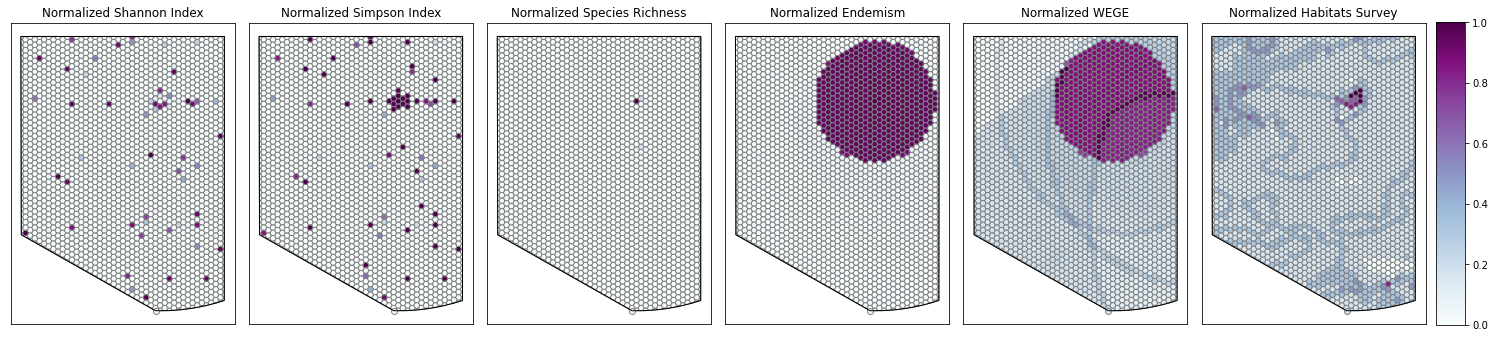

In [28]:
# Create the figure and subplots
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, figsize=(20, 10))

gdf.plot(column='mbu_shannon_index', cmap='BuPu', edgecolor="grey", ax=ax1)
gpd.GeoSeries(ACMC.geometry).plot(ax=ax1, edgecolor='black', facecolor='none')
ax1.yaxis.set_ticks([])
ax1.xaxis.set_ticks([])
ax1.set_title('Normalized Shannon Index')

gdf.plot(column='mbu_simpson_index', cmap='BuPu', edgecolor="grey", ax=ax2)
gpd.GeoSeries(ACMC.geometry).plot(ax=ax2, edgecolor='black', facecolor='none')
ax2.yaxis.set_ticks([])
ax2.xaxis.set_ticks([])
ax2.set_title('Normalized Simpson Index')

gdf.plot(column='mbu_species_richness', cmap='BuPu', edgecolor="grey", ax=ax3)
gpd.GeoSeries(ACMC.geometry).plot(ax=ax3, edgecolor='black', facecolor='none')
ax3.yaxis.set_ticks([])
ax3.xaxis.set_ticks([])
ax3.set_title('Normalized Species Richness')

gdf.plot(column='mbu_endemism', cmap='BuPu', edgecolor="grey", ax=ax4)
gpd.GeoSeries(ACMC.geometry).plot(ax=ax4, edgecolor='black', facecolor='none')
ax4.yaxis.set_ticks([])
ax4.xaxis.set_ticks([])
ax4.set_title('Normalized Endemism')

gdf.plot(column='mbu_wege', cmap='BuPu', edgecolor="grey", ax=ax5)
gpd.GeoSeries(ACMC.geometry).plot(ax=ax5, edgecolor='black', facecolor='none')
ax5.yaxis.set_ticks([])
ax5.xaxis.set_ticks([])
ax5.set_title('Normalized WEGE')

gdf.plot(column='mbu_habitats_survey', cmap='BuPu', edgecolor="grey", ax=ax6)
gpd.GeoSeries(ACMC.geometry).plot(ax=ax6, edgecolor='black', facecolor='none')
ax6.yaxis.set_ticks([])
ax6.xaxis.set_ticks([])
ax6.set_title('Normalized Habitats Survey')

# Create a shared colorbar axis at the end (right side) vertically
cax = fig.add_axes([1, 0.29, 0.02, 0.42])  # Adjust the coordinates and size as needed

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap='BuPu')
sm.set_array([])  # Set an empty array for now

# Create a shared vertical colorbar with adjusted size
cbar = plt.colorbar(sm, cax=cax, orientation="vertical", fraction=0.05)  # Adjust the fraction parameter

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Display the plot
plt.show()

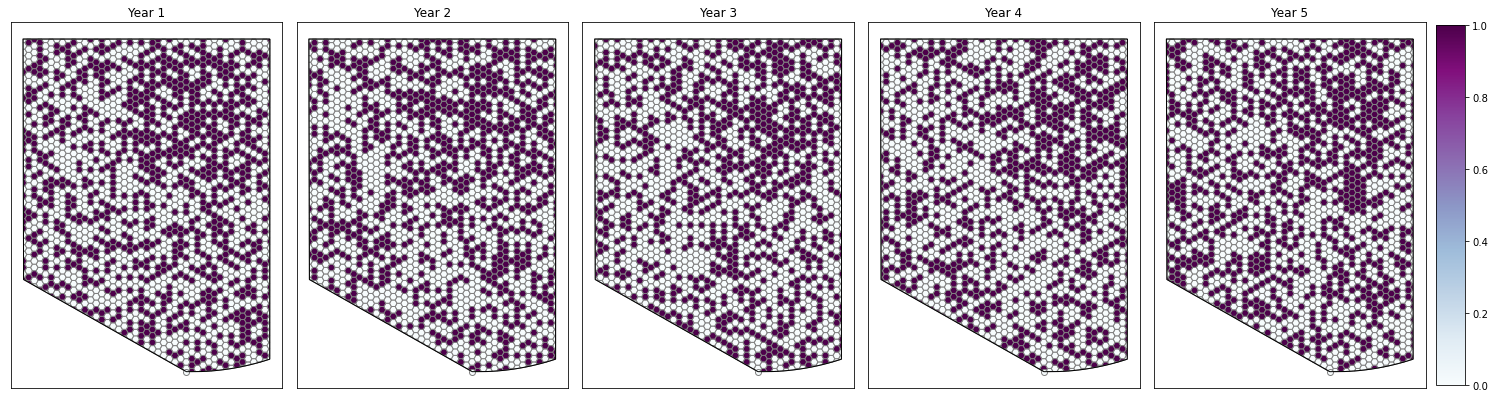

In [31]:
# Create the figure and subplots
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(20, 10))

over_time_df.plot(column='y1_credit', cmap='BuPu', edgecolor="grey", ax=ax1)
gpd.GeoSeries(ACMC.geometry).plot(ax=ax1, edgecolor='black', facecolor='none')
ax1.yaxis.set_ticks([])
ax1.xaxis.set_ticks([])
ax1.set_title('Year 1')

over_time_df.plot(column='y2_credit', cmap='BuPu', edgecolor="grey", ax=ax2)
gpd.GeoSeries(ACMC.geometry).plot(ax=ax2, edgecolor='black', facecolor='none')
ax2.yaxis.set_ticks([])
ax2.xaxis.set_ticks([])
ax2.set_title('Year 2')

over_time_df.plot(column='y3_credit', cmap='BuPu', edgecolor="grey", ax=ax3)
gpd.GeoSeries(ACMC.geometry).plot(ax=ax3, edgecolor='black', facecolor='none')
ax3.yaxis.set_ticks([])
ax3.xaxis.set_ticks([])
ax3.set_title('Year 3')

over_time_df.plot(column='y4_credit', cmap='BuPu', edgecolor="grey", ax=ax4)
gpd.GeoSeries(ACMC.geometry).plot(ax=ax4, edgecolor='black', facecolor='none')
ax4.yaxis.set_ticks([])
ax4.xaxis.set_ticks([])
ax4.set_title('Year 4')

over_time_df.plot(column='y5_credit', cmap='BuPu', edgecolor="grey", ax=ax5)
gpd.GeoSeries(ACMC.geometry).plot(ax=ax5, edgecolor='black', facecolor='none')
ax5.yaxis.set_ticks([])
ax5.xaxis.set_ticks([])
ax5.set_title('Year 5')

# Create a shared colorbar axis at the end (right side) vertically
cax = fig.add_axes([1, 0.25, 0.02, 0.5])  # Adjust the coordinates and size as needed

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap='BuPu')
sm.set_array([])  # Set an empty array for now

# Create a shared vertical colorbar with adjusted size
cbar = plt.colorbar(sm, cax=cax, orientation="vertical", fraction=0.05)  # Adjust the fraction parameter

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Display the plot
plt.show()

In [33]:
for year in list_years:
    print(over_time_df[f'{year}_credit'].sum())

963
943
906
917
982
